# Audio-ECoG Correlation Analysis Pipeline

## Overview
This pipeline analyzes the correlation between continuous auditory stimuli (perceived intensity/volume) and neural recordings from human ECoG data.

**Starting Data:**
- Audio: 30 minutes at 44,100 Hz (79,380,000 samples)
- ECoG: 30 minutes at 512 Hz (921,600 samples) for 9 subjects

**Goal:**
- Compare auditory intensity envelope with neural high-gamma power
- Find optimal lag using 10-fold cross-validation
- Z-score normalize across all subjects

## Part 1: Audio Processing

### Step 1: Extract Envelope with Hilbert Transform

**Purpose:** Extract the amplitude envelope (overall loudness pattern) from the raw audio signal

**Input:** Raw audio waveform at 44,100 Hz with fast oscillations

**Process:**
- Apply Hilbert transform to create analytic signal
- Extract absolute value to get instantaneous amplitude

**Output:** Audio envelope at 44,100 Hz tracking overall amplitude over time

**Why Hilbert?** Gives instantaneous amplitude at each time point without windowing, standard method in neuroscience

In [1]:
import numpy as np
from scipy.signal import hilbert
import soundfile as sf  # pip install soundfile (or use librosa.load)

def load_audio(path: str, target_sr: int = 44100):
    """
    Reads an audio file and ensures it is sampled at 44,100Hz.

    Parameters
    ----------
    path : str
        Path to the audio file.
    target_sr : int, default 44100
        Desired sampling rate.

    Returns
    -------
    waveform : np.ndarray
        Mono waveform normalized to [-1, 1].
    sr : int
        Sampling rate (should be `target_sr`).
    """
    waveform, sr = sf.read(path, dtype="float32", always_2d=False)
    if sr != target_sr:
        raise ValueError(f"Expected {target_sr}Hz audio, got {sr}Hz.")
    if waveform.ndim > 1:
        waveform = np.mean(waveform, axis=1)  # Convert to mono by averaging channels
    return waveform, sr

def hilbert_envelope(waveform: np.ndarray) -> np.ndarray:
    """
    Extracts the amplitude envelope of a real-valued waveform using the Hilbert transform.

    Parameters
    ----------
    waveform : np.ndarray
        Real-valued time series sampled at 44,100Hz.

    Returns
    -------
    envelope : np.ndarray
        Instantaneous amplitude at each sample (same length as `waveform`).
    """
    analytic_signal = hilbert(waveform)
    envelope = np.abs(analytic_signal)
    return envelope


audio_path = "/scratch/gpfs/HASSON/gidon/podcast-benchmark/data/stimuli/podcast.wav" 
waveform, sr = load_audio(audio_path)
envelope = hilbert_envelope(waveform)

print(f"Waveform length: {waveform.shape[0]} samples")
print(f"Envelope length: {envelope.shape[0]} samples")

Waveform length: 79380000 samples
Envelope length: 79380000 samples


### Step 2: Lowpass Filter the Envelope

**Purpose:** Remove high-frequency noise and prevent aliasing when downsampling

**Input:** Audio envelope at 44,100 Hz

**Process:**
- Design 4th order Butterworth lowpass filter with 50 Hz cutoff
- Apply zero-phase filtering (filtfilt) to avoid time shifts

**Output:** Smoothed audio envelope at 44,100 Hz

**Why 50 Hz cutoff?**
- Envelope modulations are typically slower than 50 Hz
- Must stay well below Nyquist frequency of target rate (512/2 = 256 Hz)
- Prevents aliasing artifacts

In [2]:
import torch
torch.cuda.is_available()

True

In [3]:
import numpy as np
from scipy.signal import butter, sosfiltfilt, sosfilt
import warnings

def butterworth_lowpass_envelope(
    envelope: np.ndarray,
    sr: int,
    cutoff_hz: float = 8.0,   # default tuned for volume-level tracking
    order: int = 4,
    zero_phase: bool = True,
) -> np.ndarray:
    """
    Robust zero-phase (or causal) Butterworth lowpass for 1D envelope arrays.
    - Uses SOS (second-order sections) filtering for numerical stability.
    - Falls back to causal filtering if the input is too short for filtfilt-like operation.
    """
    if cutoff_hz <= 0:
        raise ValueError("cutoff_hz must be > 0.")
    nyq = 0.5 * sr
    if cutoff_hz >= nyq:
        raise ValueError(f"cutoff_hz ({cutoff_hz}) must be < Nyquist ({nyq}).")

    # ensure 1D array
    x = np.asarray(envelope)
    if x.ndim != 1:
        raise ValueError("Expected 1D envelope array. If multi-channel, call per-channel or pass averaged envelope.")

    # design sos filter
    sos = butter(order, cutoff_hz/nyq, btype="low", output="sos")

    # if zero-phase requested, try sosfiltfilt; if too short, fallback to causal sosfilt
    if zero_phase:
        try:
            # sosfiltfilt will raise if input is too short for the implicit padlen
            return sosfiltfilt(sos, x)
        except Exception as e:
            warnings.warn(
                f"sosfiltfilt failed ({e}); falling back to causal filtering (may introduce phase delay).",
                RuntimeWarning,
            )
            return sosfilt(sos, x)
    else:
        # causal filtering (no pad issues)
        return sosfilt(sos, x)
    

smoothed = butterworth_lowpass_envelope(envelope, sr=sr, cutoff_hz=8.0, order=4, zero_phase=True)



### Checks

In [4]:
def check_signal_stats(signal: np.ndarray, label: str = "signal"):
    """
    Print basic stats of a 1D signal for quick sanity-checks.
    """
    print(f"--- {label} ---")
    print(f"Length: {len(signal)} samples")
    print(f"Min / Max: {signal.min():.6f} / {signal.max():.6f}")
    print(f"Mean: {signal.mean():.6f}, Std: {signal.std():.6f}")
    print(f"Any NaNs? {np.isnan(signal).any()}")
    print()
check_signal_stats(waveform, "Waveform")
check_signal_stats(envelope, "Envelope")
check_signal_stats(smoothed, "Smoothed Envelope")

--- Waveform ---
Length: 79380000 samples
Min / Max: -0.780640 / 0.802765
Mean: 0.000169, Std: 0.082201
Any NaNs? False

--- Envelope ---
Length: 79380000 samples
Min / Max: 0.000000 / 1.173595
Mean: 0.077123, Std: 0.086984
Any NaNs? False

--- Smoothed Envelope ---
Length: 79380000 samples
Min / Max: -0.026981 / 0.506109
Mean: 0.077124, Std: 0.065437
Any NaNs? False



### Step 3: Downsample to Match ECoG Sampling Rate

**Purpose:** Match the sampling rate of ECoG data (512 Hz)

**Input:** Smoothed envelope at 44,100 Hz (~79M samples)

**Process:**
- Use `resample_poly` with up=512, down=44100
- Polyphase filtering provides efficient, high-quality resampling with built-in anti-aliasing

**Output:** Audio envelope at 512 Hz (~921,600 samples)

**Why resample_poly?**
- Handles non-integer decimation ratios efficiently
- Automatic anti-aliasing filter
- Standard approach in signal processing

In [4]:
import numpy as np
from scipy.signal import resample_poly

# envelope: 1D numpy array at sr_in (44_100)
sr_in = 44100
sr_out = 512

# reduce up/down by gcd for efficiency
from math import gcd
g = gcd(sr_out, sr_in)
up = sr_out // g
down = sr_in // g

envelope_ds = resample_poly(envelope, up, down)

print(f"Original length: {len(envelope)} samples (sr={sr_in})")
print(f"Resampled length: {len(envelope_ds)} samples (sr={sr_out})", f"Expected length: {int(np.round(len(envelope) * sr_out / sr_in))} samples")

Original length: 79380000 samples (sr=44100)
Resampled length: 921600 samples (sr=512) Expected length: 921600 samples


### Step 4: Log Transform

**Purpose:** Match perceptual loudness scaling and improve correlation with neural data

**Input:** Audio envelope at 512 Hz (linear scale)

**Process:**
- Apply log10 transform (add small epsilon to avoid log(0))

**Output:** Log-transformed audio envelope at 512 Hz

**Why log transform?**
- Matches how we perceive loudness (decibel scale)
- Compresses large values, expands small values
- Neural responses often better correlated with log-scaled stimuli

**Note:** We don't z-score the audio because it's the same for all subjects - normalization will happen during correlation analysis if needed

In [5]:
import numpy as np

def compress_envelope(env, eps=None):
    """
    Compress envelope to dB scale.
    env : 1D numpy array (>=0 expected)
    eps: small constant to avoid log(0). If None, set relative to max(env).
    """
    env = np.asarray(env, dtype=float)
    
    # Clip to >= 0; Hillbert envelope should be non-negative, but small negatives can appear due to numerical artifacts from filtering and resampling.
    env = np.clip(env, 0, None)
    
    if eps is None:
        eps = max(1e-12, env.max() * 1e-6)  # safe relative eps
    
    env_c = 20.0 * np.log10(env + eps)
    return env_c

env_db = compress_envelope(envelope_ds)
print(f"Envelope dB: min={env_db.min():.3f}, max={env_db.max():.3f}, mean={env_db.mean():.3f}")


Envelope dB: min=-122.132, max=-2.132, mean=-28.529


### Some envelope visualization


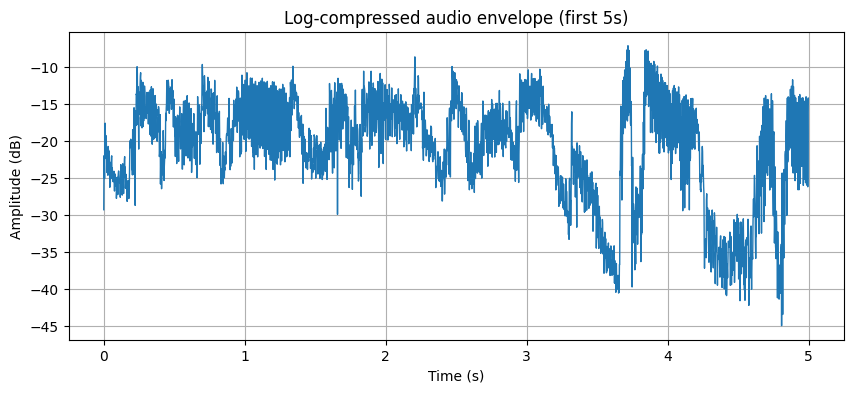

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Let's assume `env_db` is already computed as in the user's code
# We'll make a quick visualization snippet for the log-compressed envelope

def plot_envelope_db(env_db, sr_ds=512, seconds=5):
    """
    Plot the first few seconds of the dB-scaled envelope.
    
    env_db : 1D numpy array of envelope in dB
    sr_ds  : sampling rate of the downsampled envelope (default=512 Hz)
    seconds: how many seconds to visualize
    """
    n_samples = min(len(env_db), int(sr_ds * seconds))
    t = np.arange(n_samples) / sr_ds
    
    plt.figure(figsize=(10, 4))
    plt.plot(t, env_db[:n_samples], lw=1.0)
    plt.title(f"Log-compressed audio envelope (first {seconds}s)")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude (dB)")
    plt.grid(True)
    plt.show()

# Example call (would work if env_db is in scope)
# plot_envelope_db(env_db)
plot_envelope_db(env_db, sr_ds=512, seconds=5)


stds: orig, 8Hz, 30Hz: 0.086983725 0.06543740308979913 0.06982341670994492
means: orig, 8Hz, 30Hz: 0.07712324 0.07712368216264799 0.07712318983521732
corr(orig,8Hz): 0.7712860948154504
corr(orig,30Hz): 0.8053801426474215
corr(8Hz,30Hz): 0.96084157620074


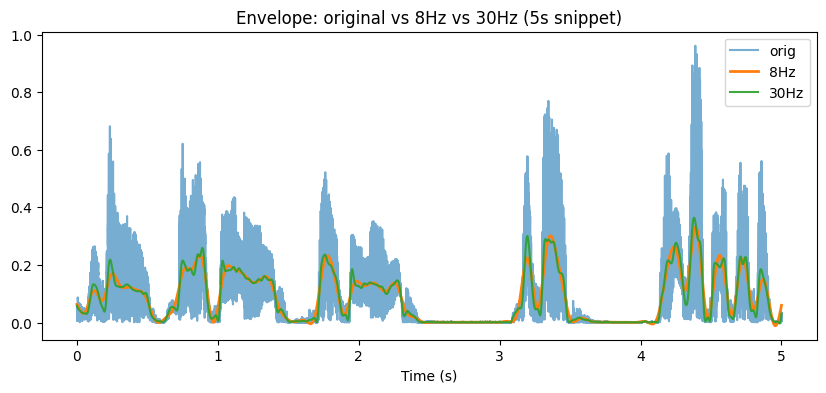

In [11]:
sm8 = butterworth_lowpass_envelope(envelope, sr=sr, cutoff_hz=8.0)
sm30 = butterworth_lowpass_envelope(envelope, sr=sr, cutoff_hz=30.0)

print("stds: orig, 8Hz, 30Hz:", envelope.std(), sm8.std(), sm30.std())
print("means: orig, 8Hz, 30Hz:", envelope.mean(), sm8.mean(), sm30.mean())
print("corr(orig,8Hz):", np.corrcoef(envelope, sm8)[0,1])
print("corr(orig,30Hz):", np.corrcoef(envelope, sm30)[0,1])
print("corr(8Hz,30Hz):", np.corrcoef(sm8, sm30)[0,1])

import matplotlib.pyplot as plt
t0 = int(10 * sr)   # start at 10s, for example
dur_s = 5
n = int(dur_s * sr)
tt = np.arange(n) / sr

plt.figure(figsize=(10,4))
plt.plot(tt, envelope[t0:t0+n], label='orig', alpha=0.6)
plt.plot(tt, sm8[t0:t0+n], label='8Hz', lw=2)
plt.plot(tt, sm30[t0:t0+n], label='30Hz', lw=1.5, alpha=0.9)
plt.legend()
plt.xlabel('Time (s)')
plt.title('Envelope: original vs 8Hz vs 30Hz (5s snippet)')
plt.show()


## Part 2: ECoG Processing (Per Subject)

### Step 1a: Bandpass Filter to High-Gamma Range (70-150 Hz)

**Purpose:** Isolate high-gamma frequency band that reflects local neural population activity

**Input:** Raw ECoG signal at 512 Hz containing all frequency bands (for each subject/electrode)

**Process:**
- Design 4th order Butterworth bandpass filter (70-150 Hz)
- Apply zero-phase filtering

**Output:** High-gamma oscillations at 512 Hz

**Why high-gamma (70-150 Hz)?**
- Strongly correlates with local neural population firing rates
- Most robust predictor of sensory and cognitive processes in ECoG
- Standard choice for studying auditory-neural coupling

**What happened to other bands?**
- Delta (1-4 Hz), theta (4-8 Hz), alpha (8-12 Hz), beta (13-30 Hz), low-gamma (30-70 Hz) are removed
- We focus only on high-gamma which best reflects local neural activity

In [6]:
import mne

def load_multiple_ieeg_files(edf_paths):
    """
    Load iEEG data from multiple EDF files.
    Returns:
        data_list: list of np.ndarray (n_electrodes, n_timepoints)
        ch_names_list: list of channel names per file
        sfreq_list: list of sample rates per file
    Checks that all files have the same number of timepoints (second dimension).
    """
    data_list = []
    ch_names_list = []
    sfreq_list = []
    n_timepoints = None
    for path in edf_paths:
        raw = mne.io.read_raw_edf(path, preload=True, verbose=False)
        data = raw.get_data()
        ch_names = raw.ch_names
        sfreq = raw.info['sfreq']
        if n_timepoints is None:
            n_timepoints = data.shape[1]
        # elif data.shape[1] != n_timepoints:
        #     raise ValueError(f"File {path} has {data.shape[1]} timepoints, expected {n_timepoints}.")
        data_list.append(data)
        ch_names_list.append(ch_names)
        sfreq_list.append(sfreq)
    return data_list, ch_names_list, sfreq_list

data_list, ch_names_list, sfreq_list = load_multiple_ieeg_files(['/scratch/gpfs/HASSON/gidon/podcast-benchmark/data/sub-01/ieeg/sub-01_task-podcast_ieeg.edf', 
                                                                 '/scratch/gpfs/HASSON/gidon/podcast-benchmark/data/sub-02/ieeg/sub-02_task-podcast_ieeg.edf', 
                                                                 '/scratch/gpfs/HASSON/gidon/podcast-benchmark/data/sub-03/ieeg/sub-03_task-podcast_ieeg.edf', 
                                                                 '/scratch/gpfs/HASSON/gidon/podcast-benchmark/data/sub-04/ieeg/sub-04_task-podcast_ieeg.edf', 
                                                                 '/scratch/gpfs/HASSON/gidon/podcast-benchmark/data/sub-05/ieeg/sub-05_task-podcast_ieeg.edf', 
                                                                 '/scratch/gpfs/HASSON/gidon/podcast-benchmark/data/sub-06/ieeg/sub-06_task-podcast_ieeg.edf', 
                                                                 '/scratch/gpfs/HASSON/gidon/podcast-benchmark/data/sub-07/ieeg/sub-07_task-podcast_ieeg.edf', 
                                                                 '/scratch/gpfs/HASSON/gidon/podcast-benchmark/data/sub-08/ieeg/sub-08_task-podcast_ieeg.edf', 
                                                                 '/scratch/gpfs/HASSON/gidon/podcast-benchmark/data/sub-09/ieeg/sub-09_task-podcast_ieeg.edf'])

ieeg_target_sr = audio_target_sr = sfreq = sfreq_list[1]

for idx in range(len(data_list)):
    print(f'Data shape for subject 0{idx+1}: {data_list[idx].shape}') # (n_electrodes, n_timepoints)

/tmp/ipykernel_2283739/2640581412.py:17: RuntimeWarning: Number of records from the header does not match the file size (perhaps the recording was not stopped before exiting). Inferring from the file size.
  raw = mne.io.read_raw_edf(path, preload=True, verbose=False)
/tmp/ipykernel_2283739/2640581412.py:17: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(path, preload=True, verbose=False)


Data shape for subject 01: (124, 921600)
Data shape for subject 02: (113, 921600)
Data shape for subject 03: (263, 921600)
Data shape for subject 04: (173, 921600)
Data shape for subject 05: (167, 921600)
Data shape for subject 06: (178, 921600)
Data shape for subject 07: (138, 3686400)
Data shape for subject 08: (91, 921600)
Data shape for subject 09: (205, 921600)


### Step 1b: Preprocessing and selecting electrodes


#### Downsample subject 07


In [7]:
import numpy as np
from scipy.signal import resample_poly

# Subject 07 index and data
subject_07_idx = 6
data_07 = data_list[subject_07_idx]
sr_07 = sfreq_list[subject_07_idx]
target_sr = ieeg_target_sr

# Calculate up/down factors for resample_poly
gcd = int(np.gcd(int(sr_07), int(target_sr)))
up = int(target_sr // gcd)
down = int(sr_07 // gcd)

# Resample each electrode separately
data_07_resampled = np.array([
    resample_poly(channel, up, down)
    for channel in data_07
], dtype=np.float32)

print(f"Subject 07 original shape: {data_07.shape}, resampled shape: {data_07_resampled.shape}")

# Replace in data_list and sfreq_list
data_list[subject_07_idx] = data_07_resampled
sfreq_list[subject_07_idx] = target_sr

Subject 07 original shape: (138, 3686400), resampled shape: (138, 921600)


#### Define electrode sets



In [8]:
all_significant_electrodes = [
    [14,16,20,21,22,23,26,27,28,41,49,55,62,73,72], #sub-01	661
    [], #sub-02	662
    [10,18,27,32,36,37,38,39,4,44,46,47,9,108,112,113,114,116,117,119,120,121,122,126,66,71,74,75,78,79,80,82,85,86,87,88,95,158,179,173,174,175,176], #sub-03 717
    [12,34,36,35,15,25,26,56,64,68,69,101,102,103,115,116,155,31,32], #sub-04	723
    [47,63,43,44,46,14,23], #sub-05	741
    [165,159,101,102,103,104,108,110,111,113,117,118,119,120,121,124,125,128,15,22,23,24,30,31,34,35,37,42,43,44,45,53,54,55,56,61,63,64,7,75], #sub-06	742
    [3,11,64,46,47,44,45,52,53,54,19,10], #sub-07	743
    [25,33,49,67,15,31,32,20,21,23,24,34,71,72,75,68], #sub-08	763
    [164,131,190,191,10,12,15,16,17,18,19,20,26,27,5,56,77,79,83,84,86,87,88,92,93,94,95,96,140,142,154], #sub-09 798
]

stg_electrodes = [
    [],
    [],
    [27, 34, 35, 36, 37, 38, 43, 44, 45, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124],
    [],
    [69, 52, 53, 61, 68, 77, 49, 41, 42, 50, 51, 48, 40],
    [99, 100, 101, 102, 108, 109, 111, 112, 117, 118, 119, 123, 124, 13,  20,  21,  28,  29,  35,  36,  37,  44,   5,  88,  89],
    [54, 45, 53, 41, 42, 43, 49, 50, 51, 52, 40, 48],
    [19, 20, 21, 22],
    [111, 112, 119, 120, 123,  41,  42,  43,  44,  50,  51,  52,  53,  54]
]

indiv_subjects = []
for data in data_list:
    n_electrodes = data.shape[0]
    if n_electrodes > 1:
        indiv_subjects.append(list(range(n_electrodes - 1)))
    else:
        indiv_subjects.append([])

#selected based on visual inspection of raw data (mean, std, peak)
bad_electrodes = [ 
    [33, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122],
    [100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111],
    [254, 255, 256, 257, 258, 259, 260, 261],
    [162, 163, 164, 165, 166, 167, 168, 169, 170, 171],
    [41, 131, 161, 162, 163, 164, 165],
    [128, 137, 159, 174, 175, 176],
    [78, 79, 80, 81, 82, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136],
    [41, 58, 75, 82, 83, 84, 85, 86, 87, 88, 89], 
    [58, 59, 60, 192, 193, 194, 195, 196, 197, 199, 200, 201, 202, 203]
]

all_good_electrodes = []
for subj_idx, electrodes in enumerate(indiv_subjects):
    bad = set(bad_electrodes[subj_idx])
    good = [e for e in electrodes if e not in bad]
    all_good_electrodes.append(good)


### 1C: Per-subject z-score normalization before high-gamma extraction
We normalize each subject's broadband signal in raw voltage units by removing its mean offset and scaling to unit variance using that subject's good electrodes. Doing this prior to any Hilbert, power, or log transforms keeps nonlinear steps from magnifying subject-specific gain differences. Later feature-level normalization still operates on the log-power signals, but now starts from data that already share a comparable baseline across subjects.

In [9]:
import numpy as np
from typing import Optional, Sequence, Tuple

def _validate_picks(n_channels: int, picks: Optional[Sequence[int]] = None) -> np.ndarray:
    if not picks:
        return np.arange(n_channels, dtype=int)
    valid = sorted({idx for idx in picks if 0 <= idx < n_channels})
    if not valid:
        return np.arange(n_channels, dtype=int)
    return np.asarray(valid, dtype=int)

def _channelwise_stats(
    data: np.ndarray,
    picks: Optional[Sequence[int]] = None,
    eps: float = 1e-8,
) -> Tuple[np.ndarray, np.ndarray]:
    """Return per-channel mean and std (shape: n_channels × 1)."""
    if data.ndim != 2:
        raise ValueError(f"Expected 2D array (channels × time), got {data.shape}")
    n_channels = data.shape[0]
    norm_idx = _validate_picks(n_channels, picks)
    data64 = np.asarray(data, dtype=np.float64)
    means = np.nanmean(data64[norm_idx, :], axis=1, keepdims=True)
    stds = np.nanstd(data64[norm_idx, :], axis=1, keepdims=True)
    stds = np.where(~np.isfinite(stds) | (stds < eps), eps, stds)
    # Broadcast back to all channels by per-channel mean/std
    full_means = np.zeros((n_channels, 1), dtype=np.float64)
    full_stds = np.zeros((n_channels, 1), dtype=np.float64)
    full_means[norm_idx, :] = means
    full_stds[norm_idx, :] = stds
    missing = np.setdiff1d(np.arange(n_channels), norm_idx)
    if missing.size:
        full_means[missing, :] = np.nanmean(data64[missing, :], axis=1, keepdims=True)
        full_stds[missing, :] = np.nanstd(data64[missing, :], axis=1, keepdims=True)
        full_stds[missing, :] = np.where(~np.isfinite(full_stds[missing, :]) | (full_stds[missing, :] < eps), eps, full_stds[missing, :])
    return full_means, full_stds

def zscore_subjects(
    data_list: Sequence[np.ndarray],
    electrode_groups: Optional[Sequence[Sequence[int]]] = None,
    eps: float = 1e-8,
) -> tuple[list[np.ndarray], dict[int, dict[str, float]]]:
    """
    Z-score each subject's channels independently (per-channel mean=0, std=1).

    Parameters
    ----------
    data_list : sequence of arrays
        Each element is (channels × time) for one subject in raw voltage units.
    electrode_groups : optional sequence
        If provided, identifies the electrodes to prioritize when computing the
        per-channel statistics. Channels not listed fall back to using their own
        mean/std estimates.
    eps : float
        Minimum standard deviation allowed to avoid division by zero.
    """
    normalized: list[np.ndarray] = []
    stats: dict[int, dict[str, float]] = {}
    for sid, data in enumerate(data_list):
        arr = np.asarray(data, dtype=np.float32)
        picks = None
        if electrode_groups and sid < len(electrode_groups):
            picks = electrode_groups[sid]
        channel_means, channel_stds = _channelwise_stats(arr, picks=picks, eps=eps)
        arr64 = arr.astype(np.float64, copy=False)
        arr_norm64 = (arr64 - channel_means) / channel_stds
        arr_norm = arr_norm64.astype(np.float32)
        normalized.append(arr_norm)
        post_mean = float(np.nanmean(arr_norm64, dtype=np.float64))
        post_std = float(np.nanstd(arr_norm64, dtype=np.float64))
        stats[sid] = {
            "global_mean": float(np.nanmean(channel_means, dtype=np.float64)),
            "global_std": float(np.nanmean(channel_stds, dtype=np.float64)),
            "post_mean": post_mean,
            "post_std": post_std,
            "n_channels": int(arr.shape[0]),
            "n_timepoints": int(arr.shape[1]),
        }
    for sid in sorted(stats):
        summary = stats[sid]
        print(
            f"Subject {sid}: per-channel z-score complete → post mean≈{summary['post_mean']:.3e}, std≈{summary['post_std']:.3e}"
        )
    return normalized, stats

In [10]:
# Apply per-subject z-scoring so downstream steps operate on comparable baselines
APPLY_SUBJECT_ZSCORE = True

if APPLY_SUBJECT_ZSCORE:
    data_list_for_processing, subject_normalization_stats = zscore_subjects(
        data_list,
        electrode_groups=all_good_electrodes,
    )
else:
    data_list_for_processing = [np.asarray(arr, dtype=np.float32) for arr in data_list]
    subject_normalization_stats = {}
    print("Skipping per-subject z-score; downstream analysis will use raw units.")

Subject 0: per-channel z-score complete → post mean≈5.792e-17, std≈1.000e+00
Subject 1: per-channel z-score complete → post mean≈-1.171e-16, std≈1.000e+00
Subject 2: per-channel z-score complete → post mean≈1.231e-17, std≈9.924e-01
Subject 3: per-channel z-score complete → post mean≈-8.488e-18, std≈9.884e-01
Subject 4: per-channel z-score complete → post mean≈1.612e-17, std≈1.000e+00
Subject 5: per-channel z-score complete → post mean≈-4.722e-17, std≈1.000e+00
Subject 6: per-channel z-score complete → post mean≈2.176e-15, std≈9.927e-01
Subject 7: per-channel z-score complete → post mean≈8.901e-18, std≈1.000e+00
Subject 8: per-channel z-score complete → post mean≈6.687e-17, std≈1.000e+00


### Step 2: Extract High-Gamma Envelope with Hilbert Transform

**Purpose:** Extract the amplitude envelope of high-gamma oscillations

**Input:** High-gamma filtered signal (70-150 Hz oscillations) at 512 Hz

**Process:**
- Apply Hilbert transform to get analytic signal
- Extract absolute value to get amplitude envelope

**Output:** High-gamma amplitude at 512 Hz (per subject/electrode)

**What this represents:**
- The envelope of high-gamma oscillations (how strong they are at each moment)
- Higher amplitude = more neural activity
- This amplitude will feed downstream log/power transforms handled in later steps

In [11]:
import numpy as np
from scipy.signal import butter, sosfiltfilt, hilbert
from collections.abc import Mapping, Sequence

ELECTRODE_GROUPS: dict[str, Sequence[Sequence[int]]] = {}
if "all_good_electrodes" in globals():
    ELECTRODE_GROUPS["all_good_electrodes"] = globals()["all_good_electrodes"]
if "all_significant_electrodes" in globals():
    ELECTRODE_GROUPS["all_significant_electrodes"] = globals()["all_significant_electrodes"]
if "stg_electrodes" in globals():
    ELECTRODE_GROUPS["stg_electrodes"] = globals()["stg_electrodes"]

def _design_high_gamma_filter(sampling_rate: float, low: float = 70.0, high: float = 150.0, order: int = 4):
    """Create a Butterworth band-pass filter for the high-gamma range."""
    if sampling_rate <= 0:
        raise ValueError("sampling_rate must be positive.")
    if not (0 < low < high < sampling_rate * 0.5):
        raise ValueError("Require 0 < low < high < Nyquist frequency.")
    nyquist = 0.5 * sampling_rate
    return butter(order, [low / nyquist, high / nyquist], btype="band", output="sos")

def bandpass_high_gamma(data: np.ndarray, sampling_rate: float, low: float = 70.0, high: float = 150.0, order: int = 4) -> np.ndarray:
    """Band-pass each electrode signal into the high-gamma range."""
    sos = _design_high_gamma_filter(sampling_rate, low=low, high=high, order=order)
    return sosfiltfilt(sos, data, axis=-1)

def _coerce_indices(indices, n_channels: int):
    if isinstance(indices, slice):
        return list(range(*indices.indices(n_channels)))
    coerced = sorted({int(i) for i in np.atleast_1d(indices)})
    for idx in coerced:
        if not 0 <= idx < n_channels:
            raise IndexError(f"Channel index {idx} out of range (0-{n_channels-1}).")
    return coerced

def _resolve_electrode_selection(selection, sid: int, n_channels: int, n_subjects: int):
    if selection is None:
        return list(range(n_channels)), "all"
    if isinstance(selection, str):
        group = ELECTRODE_GROUPS.get(selection)
        if group is None:
            raise ValueError(f"Unknown electrode group '{selection}'. Available: {list(ELECTRODE_GROUPS)}")
        if sid >= len(group):
            raise ValueError(f"Group '{selection}' has no entry for subject {sid}.")
        indices = group[sid]
        if indices is None or len(indices) == 0:
            return list(range(n_channels)), selection
        return _coerce_indices(indices, n_channels), selection
    if isinstance(selection, Mapping):
        indices = selection.get(sid)
        if indices is None:
            return list(range(n_channels)), "all"
        return _coerce_indices(indices, n_channels), "mapping"
    if isinstance(selection, Sequence) and not isinstance(selection, (str, bytes, bytearray)):
        if len(selection) != n_subjects:
            raise ValueError("Sequence electrode_selection must have one entry per subject.")
        indices = selection[sid]
        if indices is None:
            return list(range(n_channels)), "all"
        return _coerce_indices(indices, n_channels), "sequence"
    return _coerce_indices(selection, n_channels), "custom"

def extract_high_gamma_amplitude(
    data_list: list[np.ndarray],
    sfreq_list: list[float],
    low: float = 70.0,
    high: float = 150.0,
    order: int = 4,
    electrode_selection=None,
    verbose: bool = True,
 ) -> dict[int, dict[str, np.ndarray]]:
    """
    Compute high-gamma bandpassed signals and Hilbert amplitudes for each subject/electrode.

    Parameters
    ----------
    data_list : list of np.ndarray
        Each array has shape (n_electrodes, n_samples) and contains the broadband ECoG.
    sfreq_list : list of float
        Sampling rate (Hz) for each subject array.
    low, high : float
        Band-pass edges for the high-gamma filter.
    order : int
        Butterworth filter order.
    electrode_selection : None | str | Mapping | Sequence
        Optional specification of which electrodes to include per subject.
        - None: use all electrodes.
        - str: look up a group defined in `ELECTRODE_GROUPS` (e.g. "all_good_electrodes").
        - Mapping: subject index -> iterable of channel indices.
        - Sequence: one entry per subject, each entry giving channel indices.
    verbose : bool
        If True, print basic shape information for sanity-checking.

    Returns
    -------
    dict[int, dict[str, np.ndarray]]
        For each subject index, returns the filtered signal, amplitude envelope,
        the sampling rate, and the indices that were used.
    """
    if len(data_list) != len(sfreq_list):
        raise ValueError("data_list and sfreq_list must have the same length.")

    n_subjects = len(data_list)
    results: dict[int, dict[str, np.ndarray]] = {}
    for sid, (raw, sr) in enumerate(zip(data_list, sfreq_list)):
        raw = np.asarray(raw, dtype=np.float32)
        if raw.ndim != 2:
            raise ValueError(f"Subject {sid}: expected (n_electrodes, n_samples), got {raw.shape}")

        indices, label = _resolve_electrode_selection(electrode_selection, sid, raw.shape[0], n_subjects)
        raw_sel = raw[indices, :]
        if raw_sel.ndim == 1:
            raw_sel = raw_sel[np.newaxis, :]

        filtered = bandpass_high_gamma(raw_sel, sr, low=low, high=high, order=order)
        amplitude = np.abs(hilbert(filtered, axis=-1))

        results[sid] = {
            "filtered": filtered,
            "amplitude": amplitude,
            "sampling_rate": sr,
            "bandpass": (low, high),
            "electrode_indices": indices,
            "electrode_label": label,
        }

        if verbose:
            print(
                f"Subject {sid}: electrodes={label}, filtered {filtered.shape}, amplitude {amplitude.shape}"
            )

    return results

In [12]:
hg_results = extract_high_gamma_amplitude(
    data_list_for_processing,
    sfreq_list,
    electrode_selection="all_good_electrodes",
    verbose=False,
 )

### Step 3: Log Transform

**Purpose:** Stabilize variance and make distribution more Gaussian

**Input:** High-gamma power at 512 Hz (linear scale)

**Process:**
- Apply log10 transform (add small epsilon to avoid log(0))

**Output:** Log-scaled high-gamma power at 512 Hz (per subject/electrode)

**Why log transform?**
- Neural power spans a large dynamic range (several orders of magnitude)
- Log transform compresses this range
- Makes distribution more Gaussian (better for correlation analysis)
- Standard practice in ECoG/EEG power analysis

In [13]:
import numpy as np

# Straightforward log10 transform with per-subject epsilon
hg_log_results = {}
summary_lines = []

for sid, payload in hg_results.items():
    amp = np.asarray(payload["amplitude"], dtype=np.float32)
    eps = max(1e-12, float(amp.max()) * 1e-6)
    log_amp = np.log10(np.clip(amp, 0.0, None) + eps)

    payload["log_amplitude"] = log_amp
    payload["log_eps"] = eps
    hg_log_results[sid] = payload

    summary_lines.append(
        f"Subject {sid}: log-HG mean={log_amp.mean():.4f}, std={log_amp.std():.4f}, eps={eps:.2e}"
    )

print("\n".join(summary_lines))

Subject 0: log-HG mean=-1.2340, std=0.3414, eps=5.06e-05
Subject 1: log-HG mean=-1.3991, std=0.3574, eps=2.32e-05
Subject 2: log-HG mean=-1.3640, std=0.3960, eps=3.87e-05
Subject 3: log-HG mean=-1.2132, std=0.3664, eps=3.18e-05
Subject 4: log-HG mean=-1.2470, std=0.4456, eps=3.12e-05
Subject 5: log-HG mean=-1.5653, std=0.3486, eps=3.35e-05
Subject 6: log-HG mean=-1.2485, std=0.3661, eps=8.56e-06
Subject 7: log-HG mean=-1.4962, std=0.3529, eps=3.58e-05
Subject 8: log-HG mean=-1.4654, std=0.3608, eps=6.71e-06


## Part 4: Single-Lag Ridge Sweep
 
### Goal
Evaluate one latency at a time by shifting the audio predictor relative to a single subject's z-scored high-gamma response. For each lag between −1000 ms and +1000 ms (10 ms steps) we fit a one-feature Ridge regression with a cross-validated alpha and record the resulting $R^2$. The outcome is a latency tuning curve that shows where the audio envelope best predicts the neural activity.

### Step 1: Choose Subject and Electrode Set
 
* Pick one subject for debugging (e.g., Subject 0).
* Optionally pick a subset of electrodes; otherwise we use every available electrode as an input feature.
* Trim the audio envelope and neural matrix to identical lengths so the lag shifts remain consistent.

In [14]:
import numpy as np
from collections.abc import Mapping

# ------------------------------------------------------------------
# Latency sweep configuration
# ------------------------------------------------------------------
analysis_modes = [
    "per_subject",
    "average",
    "pooled_electrodes",
]  # choose any subset of {"per_subject", "average", "pooled_electrodes"}
selected_subject_ids = sorted(hg_log_results.keys())  # adjust to focus on specific subjects
electrode_selector = None  # None -> keep all electrodes; can also be sequence, dict, or callable
ridge_cv_splits = 10
device_preference = None  # e.g. "cuda", "cpu", or None for auto-selection
progress_every = 10  # print ETA every N evaluated lags when verbose=True
enforce_global_alignment = True  # ensure pooled runs share identical sample counts


def _select_indices(subject_id: int, total_channels: int, selector) -> np.ndarray | None:
    """Resolve an electrode selection policy into concrete indices."""
    if selector is None:
        return None
    if callable(selector):
        picked = selector(subject_id, total_channels)
    elif isinstance(selector, Mapping):
        picked = selector.get(subject_id)
    else:
        picked = selector
    if picked is None:
        return None
    idx = np.asarray(list(picked), dtype=int)
    if idx.size == 0:
        raise ValueError(f"Electrode selector for subject {subject_id} returned no indices.")
    if np.any(idx < 0) or np.any(idx >= total_channels):
        raise ValueError(
            f"Electrode selector for subject {subject_id} produced out-of-range indices (0-{total_channels - 1})."
        )
    return idx


valid_modes = {"per_subject", "average", "pooled_electrodes"}
invalid_modes = [mode for mode in analysis_modes if mode not in valid_modes]
if invalid_modes:
    raise ValueError(f"Unknown analysis mode(s): {invalid_modes}. Valid options: {sorted(valid_modes)}")

subject_datasets: list[dict] = []
subject_dataset_lookup: dict[int, dict] = {}

for subject_id in selected_subject_ids:
    if subject_id not in hg_log_results:
        print(f"Skipping subject {subject_id}: not present in hg_log_results.")
        continue
    payload = hg_log_results[subject_id]
    neural_key = "zscore_log_amplitude" if "zscore_log_amplitude" in payload else "log_amplitude"
    neural_matrix = np.asarray(payload[neural_key], dtype=np.float32, order="C")
    base_labels = payload.get("electrode_indices")
    if base_labels is None or len(base_labels) != neural_matrix.shape[0]:
        base_labels = list(range(neural_matrix.shape[0]))
    idx = _select_indices(subject_id, neural_matrix.shape[0], electrode_selector)
    if idx is not None:
        neural_matrix = neural_matrix[idx]
        electrode_labels = [base_labels[int(i)] for i in idx]
    else:
        electrode_labels = list(base_labels)
    audio_series_subject = np.asarray(env_db, dtype=np.float32)
    sampling_rate = float(payload["sampling_rate"])
    min_len = min(audio_series_subject.size, neural_matrix.shape[1])
    if min_len <= 0:
        print(f"Skipping subject {subject_id}: zero-length alignment after trimming.")
        continue
    dataset = {
        "subject_id": subject_id,
        "neural": neural_matrix[:, :min_len],
        "audio": audio_series_subject[:min_len],
        "sampling_rate": sampling_rate,
        "electrode_labels": electrode_labels,
        "neural_key": neural_key,
    }
    subject_datasets.append(dataset)
    subject_dataset_lookup[subject_id] = dataset

if not subject_datasets:
    raise RuntimeError("No subject datasets prepared; adjust selected_subject_ids or electrode_selector.")

sampling_rates = {ds["sampling_rate"] for ds in subject_datasets}
if len(sampling_rates) != 1:
    raise ValueError(f"Sampling rates differ across subjects: {sorted(sampling_rates)}")
shared_sampling_rate = sampling_rates.pop()

if enforce_global_alignment and len(subject_datasets) > 1:
    global_min_length = min(ds["audio"].shape[0] for ds in subject_datasets)
    if global_min_length <= 0:
        raise RuntimeError("Computed non-positive global minimum length for alignment.")
    for ds in subject_datasets:
        if ds["audio"].shape[0] != global_min_length:
            ds["audio"] = ds["audio"][:global_min_length]
            ds["neural"] = ds["neural"][:, :global_min_length]
    print(
        f"Aligned all subject series to {global_min_length} samples (~{global_min_length / shared_sampling_rate / 60:.1f} min)."
    )
else:
    global_min_length = subject_datasets[0]["audio"].shape[0]

pooled_dataset = None
if "pooled_electrodes" in analysis_modes:
    pooled_neural = np.concatenate([ds["neural"] for ds in subject_datasets], axis=0)
    pooled_labels = []
    for ds in subject_datasets:
        pooled_labels.extend([(ds["subject_id"], lbl) for lbl in ds["electrode_labels"]])
    pooled_dataset = {
        "subject_id": "pooled",
        "neural": pooled_neural,
        "audio": subject_datasets[0]["audio"],
        "sampling_rate": shared_sampling_rate,
        "electrode_labels": pooled_labels,
        "component_subject_ids": [ds["subject_id"] for ds in subject_datasets],
    }

print(
    "Prepared ridge datasets for subjects: "
    + ", ".join(str(ds["subject_id"]) for ds in subject_datasets)
    + f" (shared length {global_min_length} samples)."
 )
for ds in subject_datasets:
    print(
        f"  Subject {ds['subject_id']}: {ds['neural'].shape[0]} electrodes, {ds['audio'].shape[0]} samples, feature key='{ds['neural_key']}'"
    )
if pooled_dataset is not None:
    print(
        f"Pooled electrodes mode will use {pooled_dataset['neural'].shape[0]} total electrodes across {len(pooled_dataset['component_subject_ids'])} subjects."
    )

ridge_analysis_config = {
    "analysis_modes": analysis_modes,
    "cv_splits": ridge_cv_splits,
    "device": device_preference,
    "progress_every": progress_every,
    "selected_subject_ids": selected_subject_ids,
    "sampling_rate": shared_sampling_rate,
}

Aligned all subject series to 921600 samples (~30.0 min).
Prepared ridge datasets for subjects: 0, 1, 2, 3, 4, 5, 6, 7, 8 (shared length 921600 samples).
  Subject 0: 110 electrodes, 921600 samples, feature key='log_amplitude'
  Subject 1: 100 electrodes, 921600 samples, feature key='log_amplitude'
  Subject 2: 254 electrodes, 921600 samples, feature key='log_amplitude'
  Subject 3: 162 electrodes, 921600 samples, feature key='log_amplitude'
  Subject 4: 159 electrodes, 921600 samples, feature key='log_amplitude'
  Subject 5: 171 electrodes, 921600 samples, feature key='log_amplitude'
  Subject 6: 117 electrodes, 921600 samples, feature key='log_amplitude'
  Subject 7: 79 electrodes, 921600 samples, feature key='log_amplitude'
  Subject 8: 190 electrodes, 921600 samples, feature key='log_amplitude'
Pooled electrodes mode will use 1342 total electrodes across 9 subjects.


### Step 2: Sweep Latencies with Torch-Accelerated RidgeCV
 
* Convert each lag in milliseconds to whole-sample shifts at 512 Hz.
* For every lag, align the audio predictor and neural target without padding.
* Standardize the aligned vectors, run a **10-fold** cross-validated ridge regression on the GPU (falling back to CPU when needed), and retain the best alpha and mean $R^2$ for that lag.
* Store the curve for quick inspection (DataFrame or structured NumPy array).

In [ ]:
USE_SLIDING_WINDOW_RMS = True
WINDOW_MS = 200.0  # milliseconds
HOP_MS = 25.0      # milliseconds

if USE_SLIDING_WINDOW_RMS:
    if "subject_datasets" not in globals():
        raise RuntimeError("Run the dataset preparation cell before enabling sliding-window RMS.")

    def _rms_windows(arr, window_samples, hop_samples):
        arr64 = np.asarray(arr, dtype=np.float64, order="C")
        series_len = arr64.shape[-1]
        if series_len < window_samples:
            raise ValueError(
                f"Series length {series_len} is shorter than the requested window of {window_samples} samples."
            )
        starts = np.arange(0, series_len - window_samples + 1, hop_samples, dtype=int)
        if starts.size == 0:
            raise ValueError(
                f"Hop of {hop_samples} samples yields zero windows; adjust window/hop settings."
            )
        sq = np.square(arr64, dtype=np.float64)
        cumsum = np.cumsum(sq, axis=-1, dtype=np.float64)
        pad = np.zeros((*cumsum.shape[:-1], 1), dtype=np.float64)
        cumsum = np.concatenate([pad, cumsum], axis=-1)
        start_vals = np.take(cumsum, starts, axis=-1)
        end_vals = np.take(cumsum, starts + window_samples, axis=-1)
        window_means = (end_vals - start_vals) / float(window_samples)
        return np.sqrt(window_means, dtype=np.float64).astype(np.float32)

    window_counts = []
    for ds in subject_datasets:
        sr = float(ds["sampling_rate"])
        window_samples = max(1, int(round(WINDOW_MS * sr / 1000.0)))
        hop_samples = max(1, int(round(HOP_MS * sr / 1000.0)))

        neural = np.asarray(ds["neural"], dtype=np.float32, order="C")
        audio = np.asarray(ds["audio"], dtype=np.float32, order="C")

        if neural.shape[-1] < window_samples or audio.shape[-1] < window_samples:
            raise ValueError(
                f"Subject {ds['subject_id']}: window of {window_samples} samples exceeds series length "
                f"(neural={neural.shape[-1]}, audio={audio.shape[-1]})."
            )

        neural_rms = _rms_windows(neural, window_samples, hop_samples)
        audio_rms = _rms_windows(audio[np.newaxis, :], window_samples, hop_samples)[0]

        n_windows = min(neural_rms.shape[-1], audio_rms.shape[0])
        if neural_rms.shape[-1] != n_windows:
            neural_rms = neural_rms[..., :n_windows]
        if audio_rms.shape[0] != n_windows:
            audio_rms = audio_rms[:n_windows]

        effective_sr = sr / hop_samples

        ds["neural"] = np.ascontiguousarray(neural_rms, dtype=np.float32)
        ds["audio"] = np.ascontiguousarray(audio_rms, dtype=np.float32)
        ds["sampling_rate"] = float(effective_sr)
        ds["window_params"] = {
            "mode": "rms",
            "window_ms": WINDOW_MS,
            "hop_ms": HOP_MS,
            "window_samples": window_samples,
            "hop_samples": hop_samples,
            "effective_sr": effective_sr,
        }
        subject_dataset_lookup[ds["subject_id"]] = ds
        window_counts.append(n_windows)

    min_windows = min(window_counts)
    if any(count != min_windows for count in window_counts):
        for ds in subject_datasets:
            ds["neural"] = ds["neural"][..., :min_windows]
            ds["audio"] = ds["audio"][:min_windows]
        print(f"Trimmed all subjects to {min_windows} windows for alignment.")
    else:
        print(f"Sliding-window RMS produced {min_windows} windows per subject.")

    if "pooled_dataset" in globals() and pooled_dataset is not None:
        comp_ids = pooled_dataset.get("component_subject_ids", [])
        if comp_ids:
            pooled_neural = np.concatenate(
                [subject_dataset_lookup[sid]["neural"] for sid in comp_ids],
                axis=0,
            )
            pooled_audio = subject_dataset_lookup[comp_ids[0]]["audio"]
            pooled_dataset["neural"] = pooled_neural
            pooled_dataset["audio"] = pooled_audio
            pooled_dataset["sampling_rate"] = subject_datasets[0]["sampling_rate"]
            pooled_dataset["window_params"] = subject_datasets[0].get("window_params")
            print(
                f"Pooled dataset updated: {pooled_neural.shape[0]} electrodes × {pooled_neural.shape[1]} windows."
            )
        else:
            print("Pooled dataset defined without component subject ids; skipping pooled update.")
    else:
        print("Pooled dataset not present; skipping pooled update.")

    ridge_analysis_config["sampling_rate"] = subject_datasets[0]["sampling_rate"]
    ridge_analysis_config["window_params"] = subject_datasets[0].get("window_params")
    print(
        "Sliding-window RMS enabled: "
        f"window={WINDOW_MS:.0f} ms, hop={HOP_MS:.0f} ms, "
        f"effective sampling rate ≈ {subject_datasets[0]['sampling_rate']:.2f} Hz."
    )
else:
    print("Sliding-window RMS disabled; using sample-wise sequences for encoding.")

Sliding-window RMS produced 70885 windows per subject.
Pooled dataset updated: 1342 electrodes × 70885 windows.
Sliding-window RMS enabled: window=200 ms, hop=25 ms, effective sampling rate ≈ 39.38 Hz.


In [16]:
import torch
from sklearn.model_selection import KFold
 
def align_for_lag(audio: np.ndarray, neural: np.ndarray, lag_ms: float, sr: float) -> tuple[np.ndarray, np.ndarray]:
    """Return neural design matrix (n_samples, n_features) and audio target for a given lag."""
    if neural.ndim != 2:
        raise ValueError("neural array must have shape (n_electrodes, n_samples)")
    shift_samples = int(np.round(lag_ms / 1000.0 * sr))
    if shift_samples > 0:
        if shift_samples >= neural.shape[1] or shift_samples >= audio.size:
            raise ValueError(f"Shift {shift_samples} exceeds series length {audio.size}")
        X = neural[:, shift_samples:].T
        y = audio[:-shift_samples]
    elif shift_samples < 0:
        shift = abs(shift_samples)
        if shift >= neural.shape[1] or shift >= audio.size:
            raise ValueError(f"Shift {shift} exceeds series length {audio.size}")
        X = neural[:, :-shift].T
        y = audio[shift:]
    else:
        X = neural.T
        y = audio
    length = min(X.shape[0], y.size)
    return X[:length], y[:length]
 
def _ridge_closed_form(X: torch.Tensor, y: torch.Tensor, alpha: torch.Tensor) -> torch.Tensor:
    eye = torch.eye(X.shape[1], device=X.device, dtype=X.dtype)
    gram = X.T @ X
    return torch.linalg.solve(gram + alpha * eye, X.T @ y)
 
def ridge_r2_by_lag(
    audio: np.ndarray,
    neural: np.ndarray,
    sr: float,
    lags_ms: np.ndarray,
    *,
    alphas: np.ndarray | None = None,
    cv_splits: int = 10,
    device: str | None = None,
    verbose: bool = True,
) -> dict[str, np.ndarray]:
    """
    Evaluate ridge regression latency sweeps using closed-form Torch solvers on GPU when available.

    Returns a dict with lag-wise cross-validated R^2 (mean across folds), best alpha,
    coefficient norm, and bookkeeping metadata.
    """
    if alphas is None:
        alphas = np.logspace(-4, 4, 17, dtype=float)
    else:
        alphas = np.asarray(alphas, dtype=float)
 
    lags_ms = np.asarray(lags_ms, dtype=float)
    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"
    if verbose:
        print(f"[ridge_r2_by_lag] device={device}, cv_splits={cv_splits}")
 
    results: dict[str, list] = {
        "lag_ms": [],
        "r2": [],
        "alpha": [],
        "coef_norm": [],
        "n_samples": [],
        "n_features": [],
        "train_r2": [],
    }
 
    cv = KFold(n_splits=cv_splits, shuffle=True, random_state=0)
    alpha_tensors = [torch.as_tensor(alpha, device=device, dtype=torch.float32) for alpha in alphas]
 
    with torch.no_grad():
        for lag in lags_ms:
            X_np, y_np = align_for_lag(audio, neural, float(lag), sr)
            if X_np.shape[0] <= cv_splits or y_np.size <= cv_splits:
                continue
 
            X = torch.as_tensor(X_np, device=device, dtype=torch.float32)
            y = torch.as_tensor(y_np, device=device, dtype=torch.float32)
 
            feature_std = torch.std(X, dim=0, unbiased=False)
            valid_mask = torch.isfinite(feature_std) & (feature_std > 0)
            if not torch.any(valid_mask):
                continue
            X = X[:, valid_mask]
 
            best_alpha: float | None = None
            best_cv_r2 = -np.inf
 
            for alpha_tensor, alpha_value in zip(alpha_tensors, alphas):
                fold_scores: list[float] = []
 
                for train_idx, test_idx in cv.split(np.arange(X.shape[0])):
                    train_ids = torch.as_tensor(train_idx, device=device, dtype=torch.long)
                    test_ids = torch.as_tensor(test_idx, device=device, dtype=torch.long)
 
                    X_train = X.index_select(0, train_ids)
                    X_test = X.index_select(0, test_ids)
                    y_train = y.index_select(0, train_ids)
                    y_test = y.index_select(0, test_ids)
 
                    x_mean = torch.mean(X_train, dim=0)
                    x_std = torch.std(X_train, dim=0, unbiased=False)
                    x_std = torch.where(x_std < 1e-12, torch.ones_like(x_std), x_std)
                    X_train_norm = (X_train - x_mean) / x_std
                    X_test_norm = (X_test - x_mean) / x_std
 
                    y_mean = torch.mean(y_train)
                    y_train_centered = y_train - y_mean
 
                    weights = _ridge_closed_form(X_train_norm, y_train_centered, alpha_tensor)
 
                    y_pred = X_test_norm @ weights + y_mean
                    y_test_mean = torch.mean(y_test)
 
                    ss_res = torch.sum((y_test - y_pred) ** 2)
                    ss_tot = torch.sum((y_test - y_test_mean) ** 2)
                    if ss_tot <= 0:
                        continue
                    r2 = 1.0 - (ss_res / ss_tot)
                    fold_scores.append(float(r2.detach().cpu()))
 
                if len(fold_scores) != cv_splits:
                    continue
 
                mean_cv_r2 = float(np.mean(fold_scores))
                if mean_cv_r2 > best_cv_r2:
                    best_cv_r2 = mean_cv_r2
                    best_alpha = float(alpha_value)
 
            if best_alpha is None:
                continue
 
            best_alpha_tensor = torch.as_tensor(best_alpha, device=device, dtype=torch.float32)
 
            x_mean_full = torch.mean(X, dim=0)
            x_std_full = torch.std(X, dim=0, unbiased=False)
            x_std_full = torch.where(x_std_full < 1e-12, torch.ones_like(x_std_full), x_std_full)
            X_norm_full = (X - x_mean_full) / x_std_full
            y_mean_full = torch.mean(y)
            y_center_full = y - y_mean_full
 
            weights_full = _ridge_closed_form(X_norm_full, y_center_full, best_alpha_tensor)
 
            y_pred_full = X_norm_full @ weights_full + y_mean_full
            ss_res_full = torch.sum((y - y_pred_full) ** 2)
            ss_tot_full = torch.sum((y - torch.mean(y)) ** 2)
            train_r2 = float((1.0 - ss_res_full / ss_tot_full).detach().cpu()) if ss_tot_full > 0 else np.nan
            coef_norm = float(torch.norm(weights_full).detach().cpu())
 
            results["lag_ms"].append(float(lag))
            results["r2"].append(best_cv_r2)
            results["alpha"].append(best_alpha)
            results["coef_norm"].append(coef_norm)
            results["n_samples"].append(int(y.shape[0]))
            results["n_features"].append(int(X.shape[1]))
            results["train_r2"].append(train_r2)
 
    if not results["lag_ms"]:
        return results
 
    n_rows = len(results["lag_ms"])
    results["lag_ms"] = np.asarray(results["lag_ms"], dtype=float)
    results["r2"] = np.asarray(results["r2"], dtype=float)
    results["alpha"] = np.asarray(results["alpha"], dtype=float)
    results["coef_norm"] = np.asarray(results["coef_norm"], dtype=float)
    results["n_samples"] = np.asarray(results["n_samples"], dtype=int)
    results["n_features"] = np.asarray(results["n_features"], dtype=int)
    results["train_r2"] = np.asarray(results["train_r2"], dtype=float)
    results["device"] = np.asarray([device] * n_rows, dtype=object)
    results["cv_splits"] = np.asarray([cv_splits] * n_rows, dtype=int)
    return results

In [ ]:
import pandas as pd

lags_ms = np.arange(-1000.0, 1000.0 + 10.0, 10.0, dtype=float)

if "subject_datasets" not in globals():
    raise RuntimeError("Run the previous cell to prepare subject_datasets before launching sweeps.")

analysis_modes = ridge_analysis_config["analysis_modes"]
cv_splits = ridge_analysis_config["cv_splits"]
device = ridge_analysis_config["device"]
progress_stride = 10 #ridge_analysis_config["progress_every"]

ridge_outputs: dict[str, object] = {}
ridge_plot_catalog: dict[tuple[str, object], pd.DataFrame] = {}
per_subject_results: dict[int, pd.DataFrame] = {}

if any(mode in analysis_modes for mode in ("per_subject", "average")):
    for ds in subject_datasets:
        subject_id = ds["subject_id"]
        print(f"\n=== Subject {subject_id} ({ds['neural'].shape[0]} electrodes) ===")
        results = ridge_r2_by_lag(
            ds["audio"],
            ds["neural"],
            ds["sampling_rate"],
            lags_ms,
            cv_splits=cv_splits,
            device=device,
            verbose=True,
            # progress_every=progress_stride,
        )
        df = pd.DataFrame(results)
        if df.empty:
            print("  -> No usable lags for this subject.")
            continue
        df["subject_id"] = subject_id
        df["n_electrodes"] = ds["neural"].shape[0]
        df["neural_key"] = ds["neural_key"]
        per_subject_results[subject_id] = df
        best_idx = int(df["r2"].idxmax())
        best_row = df.loc[best_idx]
        summary_cols = [
            col
            for col in ["lag_ms", "r2", "train_r2", "alpha", "coef_norm", "n_features", "cv_splits", "device"]
            if col in df.columns
        ]
        print("  -> Best lag summary:")
        print(best_row[summary_cols])
    if per_subject_results:
        ridge_outputs["per_subject"] = per_subject_results
        for sid, df in per_subject_results.items():
            ridge_plot_catalog[("per_subject", sid)] = df

average_results = None
if "average" in analysis_modes:
    if not per_subject_results:
        raise RuntimeError("Average mode requested, but no per-subject results were computed.")
    combined_df = pd.concat(per_subject_results.values(), ignore_index=True)
    grouped = combined_df.groupby("lag_ms", as_index=False).agg(
        r2_mean=("r2", "mean"),
        r2_std=("r2", "std"),
        train_r2=("train_r2", "mean"),
        alpha=("alpha", "mean"),
        coef_norm=("coef_norm", "mean"),
        n_features=("n_features", "mean"),
        n_subjects=("subject_id", "nunique"),
    )
    grouped["r2"] = grouped["r2_mean"]
    average_results = {
        "curve": grouped,
        "per_subject": combined_df,
    }
    ridge_outputs["average"] = average_results
    ridge_plot_catalog[("average", "mean")] = grouped
    best_idx = int(grouped["r2"].idxmax())
    best_row = grouped.loc[best_idx]
    print("\n=== Subject-average curve ===")
    print(best_row[[col for col in ["lag_ms", "r2", "train_r2", "alpha", "coef_norm", "n_subjects"] if col in grouped.columns]])

pooled_df = None
if "pooled_electrodes" in analysis_modes:
    if pooled_dataset is None:
        raise RuntimeError("Pooled electrodes mode requested, but pooled_dataset is unavailable.")
    print(
        f"\n=== Pooled electrodes ({pooled_dataset['neural'].shape[0]} total features, subjects {pooled_dataset['component_subject_ids']}) ==="
    )
    pooled_results = ridge_r2_by_lag(
        pooled_dataset["audio"],
        pooled_dataset["neural"],
        pooled_dataset["sampling_rate"],
        lags_ms,
        cv_splits=cv_splits,
        device=device,
        verbose=True,
        # progress_every=progress_stride,
    )
    pooled_df = pd.DataFrame(pooled_results)
    if pooled_df.empty:
        print("  -> No usable lags for the pooled configuration.")
    else:
        pooled_df["subject_id"] = "pooled"
        pooled_df["n_electrodes"] = pooled_dataset["neural"].shape[0]
        ridge_outputs["pooled_electrodes"] = pooled_df
        ridge_plot_catalog[("pooled_electrodes", "all")] = pooled_df
        best_idx = int(pooled_df["r2"].idxmax())
        best_row = pooled_df.loc[best_idx]
        print("  -> Best lag summary:")
        print(best_row[[col for col in ["lag_ms", "r2", "train_r2", "alpha", "coef_norm", "n_features"] if col in pooled_df.columns]])

available_plot_targets = list(ridge_plot_catalog.keys())
if available_plot_targets:
    print("\nAvailable plot selections:", available_plot_targets)
    plot_selection = available_plot_targets[0]
    print(f"Default plot_selection set to {plot_selection}.")
    ridge_df = ridge_plot_catalog[plot_selection]
    best_idx = int(ridge_df["r2"].idxmax())
    best_row = ridge_df.loc[best_idx]
else:
    plot_selection = None
    print("\nNo ridge results available for plotting.")


=== Subject 0 (110 electrodes) ===
[ridge_r2_by_lag] device=cuda, cv_splits=10
  -> Best lag summary:
lag_ms             120.0
r2              0.242399
train_r2        0.245108
alpha         316.227766
coef_norm       4.449319
n_features           110
cv_splits             10
device              cuda
Name: 112, dtype: object

=== Subject 1 (100 electrodes) ===
[ridge_r2_by_lag] device=cuda, cv_splits=10


### Step 3: Visualize and Inspect
 
* Plot the lag curve to see where $R^2$ peaks.
* Highlight the best-performing latency and its alpha.
* Optionally inspect neighbouring lags or repeat with different electrodes/subjects.

In [17]:
import matplotlib.pyplot as plt
from pathlib import Path
from IPython.display import display

if "ridge_plot_catalog" not in globals() or not ridge_plot_catalog:
    raise RuntimeError("No ridge results to visualize. Run the latency sweep cell first.")

if plot_selection is None or plot_selection not in ridge_plot_catalog:
    raise ValueError(
        f"plot_selection {plot_selection} is not valid. Choose one of: {list(ridge_plot_catalog.keys())}"
    )

plot_df = ridge_plot_catalog[plot_selection]
if plot_df.empty:
    raise RuntimeError(f"Selected result {plot_selection} contains no rows to plot.")

metric_series = plot_df["r2"]
best_idx = int(metric_series.idxmax())
best_row = plot_df.loc[best_idx]

mode, identifier = plot_selection
if mode == "per_subject":
    predictor_count = subject_dataset_lookup[identifier]["neural"].shape[0]
    title_suffix = f"Subject {identifier}, {predictor_count} electrode predictors"
elif mode == "average":
    predictor_count = sum(ds["neural"].shape[0] for ds in subject_datasets)
    title_suffix = f"Mean curve across {len(subject_datasets)} subjects (tracking {predictor_count} pooled electrodes)"
elif mode == "pooled_electrodes":
    predictor_count = pooled_dataset["neural"].shape[0]
    title_suffix = f"All subjects pooled ({predictor_count} electrodes)"
else:
    title_suffix = str(plot_selection)

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(plot_df["lag_ms"], metric_series, color="#1f77b4", lw=2, label="CV $R^2$")
ax.axvline(0.0, color="k", ls="--", lw=1, label="0 ms")
ax.axvline(best_row["lag_ms"], color="#ff7f0e", ls="--", lw=1.5, label=f"best lag = {best_row['lag_ms']:.0f} ms")
ax.set_xlabel("Latency shift (ms)")
ax.set_ylabel("RidgeCV $R^2$")
ax.set_title(f"Latency sweep — {title_suffix}")
ax.legend(loc="best")
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

summary_rows: list[dict] = []
if "per_subject" in ridge_outputs and isinstance(ridge_outputs["per_subject"], dict):
    for sid, df in ridge_outputs["per_subject"].items():
        if df.empty:
            continue
        idx = int(df["r2"].idxmax())
        summary_rows.append({
            "mode": "per_subject",
            "label": f"Subject {sid}",
            "lag_ms": float(df.loc[idx, "lag_ms"]),
            "r2": float(df.loc[idx, "r2"]),
        })
if "average" in ridge_outputs and ridge_outputs["average"]:
    avg_curve = ridge_outputs["average"]["curve"]
    if not avg_curve.empty:
        idx = int(avg_curve["r2"].idxmax())
        summary_rows.append({
            "mode": "average",
            "label": "Subject mean",
            "lag_ms": float(avg_curve.loc[idx, "lag_ms"]),
            "r2": float(avg_curve.loc[idx, "r2"]),
        })
if "pooled_electrodes" in ridge_outputs and isinstance(ridge_outputs["pooled_electrodes"], pd.DataFrame):
    pooled_df = ridge_outputs["pooled_electrodes"]
    if not pooled_df.empty:
        idx = int(pooled_df["r2"].idxmax())
        summary_rows.append({
            "mode": "pooled_electrodes",
            "label": "All electrodes pooled",
            "lag_ms": float(pooled_df.loc[idx, "lag_ms"]),
            "r2": float(pooled_df.loc[idx, "r2"]),
        })

if summary_rows:
    summary_table = pd.DataFrame(summary_rows).sort_values("r2", ascending=False).reset_index(drop=True)
else:
    summary_table = pd.DataFrame(columns=["mode", "label", "lag_ms", "r2"])

summary_fig = None
if not summary_table.empty:
    summary_fig, summary_ax = plt.subplots(figsize=(12, 5))
    per_subject_dict = ridge_outputs.get("per_subject", {})
    for sid, df in per_subject_dict.items():
        if df.empty:
            continue
        summary_ax.plot(df["lag_ms"], df["r2"], lw=1.5, alpha=0.6, label=f"Subject {sid}")
    if "average" in ridge_outputs and ridge_outputs["average"]:
        avg_curve = ridge_outputs["average"]["curve"]
        if not avg_curve.empty:
            summary_ax.plot(avg_curve["lag_ms"], avg_curve["r2"], color="black", lw=2.5, label="Subject mean")
    if "pooled_electrodes" in ridge_outputs:
        pooled_df = ridge_outputs["pooled_electrodes"]
        if isinstance(pooled_df, pd.DataFrame) and not pooled_df.empty:
            summary_ax.plot(pooled_df["lag_ms"], pooled_df["r2"], color="#ff7f0e", lw=2.5, ls="--", label="All electrodes pooled")
    summary_ax.axvline(0.0, color="k", ls="--", lw=1, label="0 ms")
    summary_ax.set_xlabel("Latency shift (ms)")
    summary_ax.set_ylabel("RidgeCV $R^2$")
    summary_ax.set_title("Latency sweep — subjects, mean, and pooled electrodes")
    summary_ax.legend(loc="best", ncol=2, fontsize=9)
    summary_ax.grid(True, alpha=0.3)
    summary_fig.tight_layout()

output_dir = Path("plots")
output_dir.mkdir(parents=True, exist_ok=True)
summary_path = output_dir / "ridge_latency_summary_all_subjects.png"
if summary_fig is not None:
    summary_fig.savefig(summary_path, dpi=300, bbox_inches="tight")
    plt.show()
    print(f"Saved combined latency plot to {summary_path.resolve()}")
else:
    print("Skipping combined plot export: no summary data found.")

summary_cols = [
    col
    for col in ["lag_ms", "r2", "train_r2", "alpha", "coef_norm", "n_features", "r2_std", "n_subjects"]
    if col in plot_df.columns
 ]
print("Top-performing lag (based on plotted metric):")
print(best_row[summary_cols])

if not summary_table.empty:
    print("\nBest lag per curve:")
    display(summary_table)
else:
    print("\nNo summary table available; verify that ridge outputs were generated.")

RuntimeError: No ridge results to visualize. Run the latency sweep cell first.

### Notes
 
* Ridge regression collapses to ordinary least squares when the chosen alpha is extremely small, so expect nearly identical scores for some lags.
* Because the predictors are single-column, $R^2$ mirrors squared correlation once the model is centered—yet cross-validating alpha still protects against degenerate cases at the tails.
* When scaling up, replace the simple K-fold with a blocked or leave-one-segment-out scheme to respect temporal structure.